

GSOC'20 **Task -2** for Deep Learning Algorithms for Muon Momentum Estimation in the CMS Trigger System

by Shubham Shaswat

Email: shaswat.cpp@gmail.com

In [0]:
%tensorflow_version 2.x
import tensorflow as tf

import tensorflow.keras as K
import numpy as np
import tensorflow as tf
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd



TensorFlow 2.x selected.


In [0]:
#enable tf XLA to improve performance
tf.config.optimizer.set_jit(True)

In [0]:
from mpl_toolkits.mplot3d import Axes3D


In [0]:
#I use google drive to import data
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
#path and filename of data 

#Note for your data please edit this part

path = 'drive/My Drive/Colab Data/cern'
filename = 'histos_tba.20.npz'

In [0]:
import os
os.listdir(path)

['histos_tba.20.npz']

In [0]:
#loading the data
data = np.load(os.path.join(path,filename))
lst = data.files
print(lst)

['variables', 'parameters']


In [0]:
#shape of the data
print(data['variables'].shape)

(3272341, 87)


In [0]:
#load data features for CSC

phi = data['variables'][:,0:5]
theta = data['variables'][:,12:17]


In [0]:
#contenate to make single array
train_data = np.concatenate((phi,theta),axis=1)

In [0]:
#load transvere momentum
pt=np.abs(1/(data['parameters'][:,0]))


In [0]:
#free space
del data
del phi
del theta

In [0]:
#replace the nan with 0
mask = np.isnan(train_data)
train_data = np.where(mask,0,train_data)
del mask

Conversation that I used

theta = theta * (1./16)*(pi/180)

Phi = (Phi * 1./4+10)*(pi/180)

In [0]:
#converted data into 
import math
pi=math.pi
n= train_data.shape[0]
Z = np.array([5.66,6.86,6.86,7.91,10.020]) #Z axis
Y = Z * np.tan((train_data[:n,5:10]*1/16.)*pi/180) #Y =Z*tan(theta)
X = Y / np.tan((train_data[:n,:5]*1/4.+10)*pi/180) #X = Y / tan(phi)

Text(0, 0.5, 'Y')

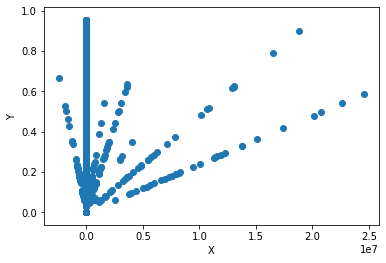

In [0]:
#plot XY plane of particles hit

plt.scatter(X[:10000,:],Y[:10000,:])
plt.xlabel('X')
plt.ylabel('Y')

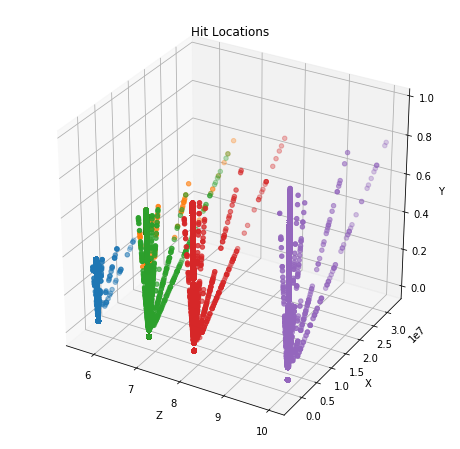

In [0]:

n=100000 #number of particles to ploy
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111, projection='3d')
  

for i in range(5):
  ax.scatter(Z[i],                                         #z axis
            X[:n,i],  #x-axis 
            Y[:n,i]) #y-axis

ax.set_title('Hit Locations')

ax.set_xlabel('Z')
ax.set_ylabel('X')
ax.set_zlabel('Y')
plt.show()             


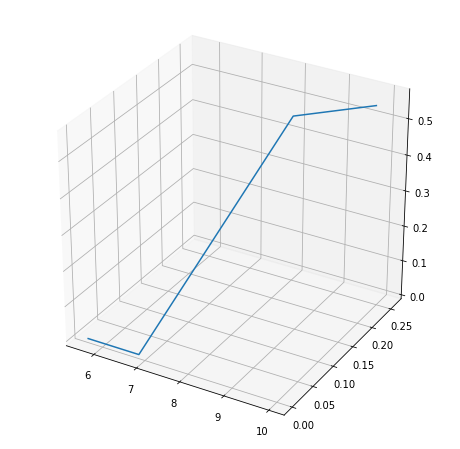

In [0]:
#draw trajectory of the particels
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111, projection='3d')
ax.plot(Z,         #z axis
        X[109,:],  #x-axis 
        Y[109,:])  #y-axi


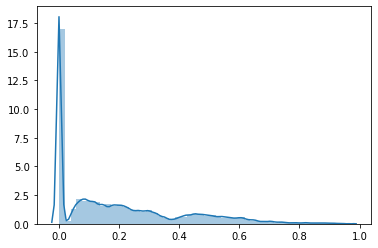

In [0]:
import seaborn as sns

#distribution plot for Y -axis
sns.distplot(Y)

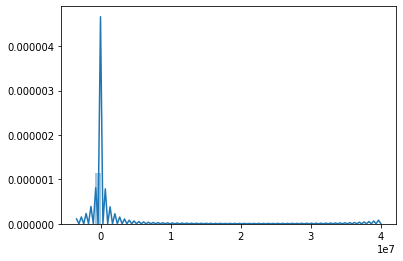

In [0]:
#distribution plot for X-axis
sns.distplot(X)

For image,the coordinates of the particle hit in (Z,Y) plane is map to pixels coordinate of 16 * 16 images

In [0]:
px = 6/15 #per pixel value for Z
py = 1/15 #per pixel value for Z

pi=3.14

#function to convert a single particle hit to image
hit_ = np.array(np.floor(np.abs(Z[:]-5.66)/px),dtype=np.uint8) #map coordinates to pixel cordinate

def to_img(y):
  j = np.array(np.floor(np.abs(y)/py),dtype=np.uint8)
  img = np.zeros((16,16,3))
  img[hit_,:,:]=1 
  img[hit_,j,:]=0 

  #rotate the array
  img=np.rot90(img)
  return img


#function to map the tensor to image
def map_fn(img,label):
  img = tf.py_function(func=to_img, inp=[img], Tout=tf.float32)
  return img,label






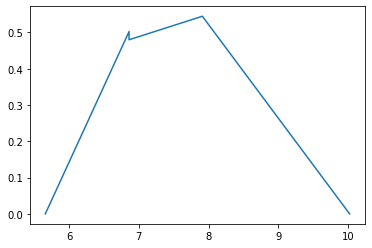

In [0]:
#plot ZY plane for a single particle
n=12129
plt.plot(Z,Y[n,:])



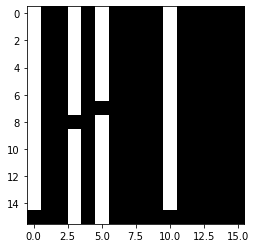

In [0]:
#our image of the particle,each columns with black pixel is the location where the particles hit
plt.imshow(to_img(Y[n,:]))

In [0]:
#buil a cnn model

from tensorflow.keras import Model
from tensorflow.keras.layers import Dense, Flatten, Conv2D, Input, Dropout,MaxPooling2D


class CNN(Model):

  def __init__(self):
    super(CNN,self).__init__()

    self.cnn1 = Conv2D(16,(3,3),activation='relu')
    self.cnn2 = Conv2D(16,(3,3),activation='relu')
    self.maxpool1 = MaxPooling2D((2,2))
    self.flatten = Flatten()
    self.dense1 = Dense(256,activation = 'relu')
    self.dropout = Dropout(.5)
    self.out = Dense(4)

  def call(self,x):

    x = self.cnn1(x)
    x = self.cnn2(x)
    x = self.maxpool1(x)
    x = self.flatten(x)
    x = self.dense1(x)
    x = self.dropout(x)
    x = self.out(x)

    return x


    


In [0]:
lr = 0.01
#loss object and optimizer
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
opt = tf.keras.optimizers.Adam(learning_rate=lr, beta_1=0.9, beta_2=0.999, amsgrad=False)

#define loss and accuracy metrics for both train and val data

train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='train_accuracy')

test_loss = tf.keras.metrics.Mean(name='test_loss')
test_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='test_accuracy')


In [0]:
#defina a train step
@tf.function
def train_step(x, y):
  with tf.GradientTape() as tape:
    
    predictions = model(x, training=True)
    loss = loss_object(y, predictions)


  gradients = tape.gradient(loss, model.trainable_variables)
  opt.apply_gradients(zip(gradients, model.trainable_variables))

  train_loss(loss)
  train_accuracy(y, predictions)



In [0]:
#test step
@tf.function
def test_step(x, y):
  
    
  predictions = model(x, training=False)
  t_loss = loss_object(y, predictions)


  test_loss(t_loss)
  test_accuracy(y, predictions)



In [0]:
#labels the momentum
pt[np.where(pt < 10)] = 0
pt[np.where((pt >= 10 )& (pt < 30))] = 1
pt[np.where((pt < 100 )& (pt >= 30))] = 2
pt[np.where(pt >= 100 )] =3
 

In [0]:
#split into train and test data,90% train data and 10% test data
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test = train_test_split(Y, pt, test_size=0.1, random_state=42)

Preparing a tf input line to feed data into model.

Using,
```
tf.dataset.map()
```
The train data is converted into a 16 * 16 * 3 images.
Using this approach will reduce training time 



In [0]:
#input pipeline for the training data

train_dataset = tf.data.Dataset.from_tensor_slices((x_train,y_train))
test_dataset = tf.data.Dataset.from_tensor_slices((x_test,y_test))



In [0]:
#create a input pipeline
BATCH_SIZE = 128

train_dataset = train_dataset.map(map_fn)
test_dataset = test_dataset.map(map_fn)

train_dataset = train_dataset.batch(BATCH_SIZE).prefetch(tf.data.experimental.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.experimental.AUTOTUNE)



In [0]:

#function to train the model
def train(EPOCHS=2,train_dataset=train_dataset,test_dataset=test_dataset):

  acc_plot=[]
  loss_plot=[]
  t_acc=[]
  t_loss=[]

  for epoch in range(EPOCHS):

    #start time
    t0 = time.time()

    # Reset the metrics at the start of the next epoch
    train_loss.reset_states()
    train_accuracy.reset_states()
    test_loss.reset_states()
    test_accuracy.reset_states()

    

    for x,y in train_dataset:
     train_step(x,y)
    
    for x,y in test_dataset:
      test_step(x, y)


    acc_plot.append(train_accuracy.result()*100)
    loss_plot.append(train_loss.result())
    
    t_acc.append(test_accuracy.result()*100)
    t_loss.append(test_loss.result())

    template = 'Epoch {}, Loss: {}, Accuracy: {}, Test Loss: {}, Test Accuracy: {}, '
    print(template.format(epoch+1,
                          train_loss.result(),
                          train_accuracy.result()*100,
                          test_loss.result(),
                          test_accuracy.result()*100,
                          
                          ))
    
  return acc_plot,t_acc,loss_plot,t_loss

In [0]:
#buidl the model for CNN
model = CNN()

In [0]:
acc_,acc_t,loss_,loss_t=train(EPOCHS=5) #each epoch took about 15-18 mins

Epoch 1, Loss: 0.6963632702827454, Accuracy: 77.17385864257812, Test Loss: 0.6956170201301575, Test Accuracy: 77.2325668334961, 
Epoch 2, Loss: 0.6960585117340088, Accuracy: 77.17593383789062, Test Loss: 0.6916823983192444, Test Accuracy: 77.23409271240234, 
Epoch 3, Loss: 0.7006970047950745, Accuracy: 77.18363952636719, Test Loss: 0.7291773557662964, Test Accuracy: 77.18826293945312, 
Epoch 4, Loss: 0.7283446788787842, Accuracy: 77.20248413085938, Test Loss: 0.7291771769523621, Test Accuracy: 77.18826293945312, 
Epoch 5, Loss: 0.7283446788787842, Accuracy: 77.20248413085938, Test Loss: 0.7291771173477173, Test Accuracy: 77.18826293945312, 


Now we will buidl a FNN model to train our image dataset

In [0]:
#define a FNN model
def FNN():

  inp = Input(shape=(16,16,3))
  x = Flatten()(inp)
  x = Dense(1000,activation='relu')(x)
  x = Dense(1000,activation='relu')(x)
  x = Dropout(0.5)(x)
  out = Dense(4)(x)

  return Model(inputs=inp,outputs=out)



In [0]:
#build model
model = FNN()


In [0]:
#train the model
acc_2,t_acc_2,loss_2,t_loss_2=train(EPOCHS=5)

Epoch 1, Loss: 0.756820023059845, Accuracy: 77.1901626586914, Test Loss: 0.7291771173477173, Test Accuracy: 77.18826293945312, 
Epoch 2, Loss: 0.7283446788787842, Accuracy: 77.20248413085938, Test Loss: 0.7291771173477173, Test Accuracy: 77.18826293945312, 
Epoch 3, Loss: 0.7283446788787842, Accuracy: 77.20248413085938, Test Loss: 0.7291771173477173, Test Accuracy: 77.18826293945312, 
Epoch 4, Loss: 0.7283446788787842, Accuracy: 77.20248413085938, Test Loss: 0.7291771173477173, Test Accuracy: 77.18826293945312, 
Epoch 5, Loss: 0.7283446788787842, Accuracy: 77.20248413085938, Test Loss: 0.7291771173477173, Test Accuracy: 77.18826293945312, 


Text(0.5, 0, 'Epoch')

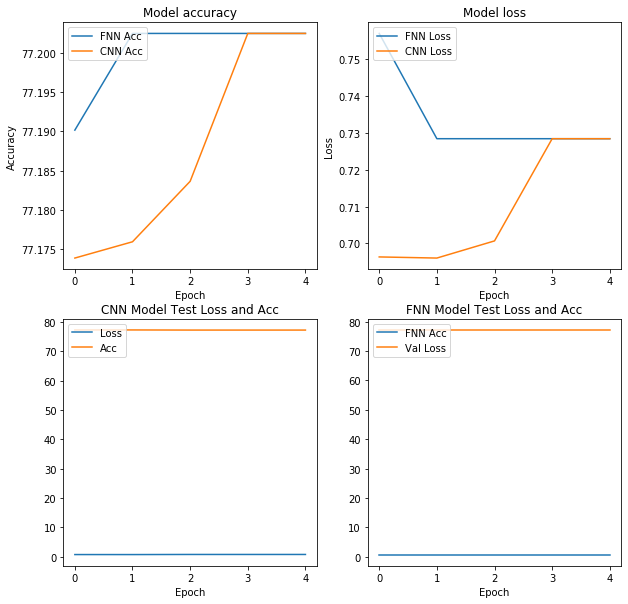

In [0]:
#plot accuracy
fig = plt.figure(figsize=(10,10))

plt.subplot(2,2,1)

plt.plot(acc_2)
plt.plot(acc_)
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['FNN Acc', 'CNN Acc'], loc='upper left')

plt.subplot(2,2,2)

plt.plot(loss_2)
plt.plot(loss_)
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['FNN Loss', 'CNN Loss'], loc='upper left')

plt.subplot(2,2,3)


plt.plot(loss_t)
plt.plot(acc_t)
plt.title('CNN Model Test Loss and Acc')
plt.legend(['Loss', 'Acc'], loc='upper left')
plt.xlabel('Epoch')

plt.subplot(2,2,4)

plt.plot(t_loss_2)
plt.plot(t_acc_2)
plt.title('FNN Model Test Loss and Acc')
plt.legend(['FNN Acc', 'Val Loss'], loc='upper left')
plt.xlabel('Epoch')





